# Willapa Bay - Summer 2025 Experiment
## Data View
### Intro

### Imports

In [2]:
from pyrsktools import RSK
import numpy as np
import matplotlib.pyplot as plt
import scipy.stats
from scipy.fft import fft, fftfreq, ifft
import pandas as pd
import xarray as xr

### RBRs (Moorings)

In [3]:
RBR_files = ['/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/EBanchor_RBR_16-27Jun2025.rsk',
             '/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/MBanchor_RBR_16-27Jun2025.rsk',
             '/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/MCanchor_RBR_17-26Jun2025.rsk',
             '/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/OSanchor_RBR_17-26Jun2025.rsk',
             '/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/SBanchor_RBR_16-27Jun2025.rsk']

#### Test File

Recall the pressure will be represented in decibars, including atmospheric pressure (which is, on average, 10.1325 dbar). 1 dbar is the same as 10000 Pascal (i.e. N/m^2), so when converting using the density of sea water, make sure to convert from dbar to Pascal. 

In [4]:
r = RSK(RBR_files[0])
r.open()
r.readdata()
r.deriveseapressure()
r.derivedepth(latitude=46.69)
r.printchannels()

Model:           RBRduo³
Serial ID:       236526
Sampling period: 0.5 second
Channels:        index                 name                  unit
                 _____     ____________________________    ________
                 0         temperature                     °C
                 1         pressure                        dbar
                 2         sea_pressure                    dbar
                 3         depth                           m


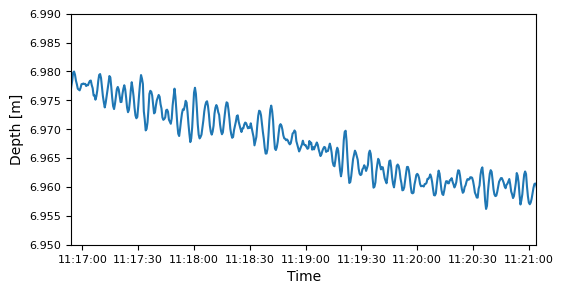

In [5]:
t = r.data['timestamp']

plt.figure(figsize=(6,3))
plt.plot(t, r.data['depth'])
plt.ylim(6.95, 6.99)
plt.xlim(t[1000000], t[1000500])
plt.tick_params(labelsize=8)
plt.xlabel("Time")
plt.ylabel("Depth [m]")
plt.show()

#### Depth Correction

Recall for a WKB wave, the wave component of the pressure (as a function of depth) is
$$
p_w = \frac{\rho a \omega^2}{k} \frac{\cosh\left[ k (z+h) \right]}{\sinh(kh)}\cos\left( kx - \omega t \right)
$$
In terms of surface elevation, that reduces to 
$$
p_w = \frac{\rho \omega^2}{k} \frac{\cosh\left[ k (z+h) \right]}{\sinh(kh)} \eta 
$$
Note: $h$ is the water depth, $z$ is 0 at the surface and positive upwards -- so the bottom is at $z=-h$. To convert from one depth to another is just a factor of 
$$
p_w(z) = p_w(z_0) \frac{\cosh\left[ k (z+h) \right]}{\cosh\left[ k (z_0+h) \right]}
$$
For the surface ($z=0$) that's 
$$
p_w(0) = p_w(z_0) \frac{\cosh(kh)}{\cosh\left[ k (z_0+h) \right]}
$$
If we want to convert from some depth to surface elevation:
$$
\eta = p_w(z_0) \frac{k}{\rho \omega^2} \frac{\sinh(kh)}{\cosh\left[ k (z_0+h) \right]}
$$
If we assume the sensor observation $p$ is located the bottom ($p_w(z) = p = p_w(z=-h)$) then
$$
\eta = p \frac{k}{\rho \omega^2} \sinh(kh)
$$
So starting with *sea pressure*, the observed pressure can be converted to estimated surface elevation using the running depth. 

First, it is necessary to compute wavenumber at the relevant depth for each frequency. Let's get some methods to do that quickly. 

In [6]:
# Shallow and deep water approximation
def k_d(omega):
    return omega**2 / g
def k_sw(omega, h):
    return omega / np.sqrt(g*h)
    
# Transcendental look-up table
kh = np.logspace(-2, 2, 100)
kh_tanh_kh = kh * np.tanh(kh)

def get_k(omega, h):
    """  omega, h must both be scalars  """
    k = np.interp(h*(omega**2)/g, kh_tanh_kh, kh, 
                  left=-1*np.inf, right=np.inf)/h
    if k == -1*np.inf: return k_sw(omega,h)
    elif k == np.inf: return k_d(omega)  
    else: return k
        
def get_k_2d(omega, h):
    """  omega, h must both be 2D arrays of equal size, 
         ...or broadcastable... maybe                    """
    k = np.interp(h*(omega**2)/g, kh_tanh_kh, kh, 
                  left=-1*np.inf, right=np.inf)/h
    k_shallow, k_deep = k_sw(omega,h), k_d(omega)
    k[k == -1*np.inf] = k_shallow[k == -1*np.inf]
    k[k ==    np.inf] = k_deep[   k ==    np.inf]
    return k

Because depth is slowly varying, I want to convert in segments. Some remarks:
1. The depth correction amplifies high frequencies, so they need to be cut off above some threshold -- usually I say 3 or 4 seconds, keeping the traditional SS band but dropping the chop. 
2. Gibbs phenomena will lead to problems at the edges, so overlap is necessary, and only the middle of each segment should be used. To do this I will use a Hanning window as the *weight* for an averaging of the segments. 
3. The mean/trend should be removed first and added back in after.
4. **I do not know the elevation of the RBR sensor port!! I will approximate it to the bed** (Ask Malcolm?)

/tmp/ipykernel_42760/2841459591.py:39: RuntimeWarning: invalid value encountered in divide
  to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2) # NOTE: assuming RBR is exactly at the bed...


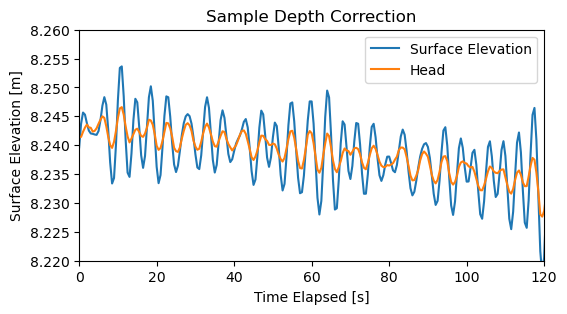

In [7]:
seg_time = 1800 # 30 minutes
dt = 0.5
seg_len = int(seg_time/dt)
overlap = 0.5
seg_starts = np.arange(0, len(t), overlap * seg_len, dtype=int)

tf = t.astype('datetime64[ms]').astype(float)/1000 # seconds in float dtype
p = r.data['sea_pressure'] * 10000                 # convert to Pascal (N/m^2)

# Stuff for computing wavenumber & conversion factors...
freq = np.abs(fftfreq(seg_len, d=dt))
omega = 2 * np.pi * freq
rho = 1025   # density of sea water in kg/m^3
g = 9.81

# Segment...
for i in seg_starts[1000:]:
    p_seg = p[i:i+seg_len]
    t_seg = tf[i:i+seg_len]
    t_seg = t_seg - t_seg[0]
    
    p_mean = np.nanmean(p_seg)   # Mean pressure
    h_mean = p_mean / (rho * g)  # Mean depth of sensor -- pressure = rho g h

    # Compute trend and detrend
    p_slope, p_intercept, _, _, _  = scipy.stats.linregress(t_seg, p_seg - p_mean)
    p_trend = p_mean + p_intercept + t_seg*p_slope
    h_trend = p_trend / (rho * g) # Also in surface elevation units
    
    p_detrended = p_seg - p_trend

    # Convert to fourier space
    F_p = fft(p_detrended)

    # Get terms for depth correction
    k = get_k_2d(omega, h_mean)

    # Correct both depth (bottom to top) and units (pressure to surface elevation) 
    to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2) # NOTE: assuming RBR is exactly at the bed...

    # Drop high frequencies otherwise amplified by this conversion. Drop 0 as well.
    to_eta[freq == 0] = 0
    to_eta[freq > 0.3] = 0
    
    # Depth correct
    F_eta = F_p * to_eta

    # Inverse fft to get surface elevation (without trend)
    eta_detrended = np.real(ifft(F_eta))
    
    # Add back in mean and trend
    eta = eta_detrended + h_trend

    # sanity plot
    plt.figure(figsize=(6,3))
    plt.plot(t_seg, eta, label='Surface Elevation')
    plt.plot(t_seg, p_seg / (rho*g), label='Head')
    plt.xlim(0, 120)
    plt.ylim(8.22, 8.26)
    plt.legend()
    plt.xlabel("Time Elapsed [s]")
    plt.ylabel("Surface Elevation [m]")
    plt.title("Sample Depth Correction")
    plt.show()
    
    # break
    break

#### Averaging Segments Together

In [8]:
def cos_taper(a):
    x = np.linspace(-np.pi/2, np.pi/2, len(a))
    return np.cos(x)

We're going to compute and combine all the segments now

In [9]:
seg_time = 1800 # 30 minutes
dt = 0.5
seg_len = int(seg_time/dt)
overlap = 0.5
seg_starts = np.arange(0, len(t) - seg_len, overlap * seg_len, dtype=int)

tf = t.astype('datetime64[ms]').astype(float)/1000 # seconds in float dtype
p = r.data['sea_pressure'] * 10000                 # convert to Pascal (N/m^2)

# Stuff for computing wavenumber & conversion factors...
freq = np.abs(fftfreq(seg_len, d=dt))
omega = 2 * np.pi * freq
rho = 1025   # density of sea water in kg/m^3
g = 9.81

# To save space, only use n arrays for averaging
n_arrays = 3

# Prepare to store etas and weights...
etas = [np.zeros(len(tf)) for i in range(n_arrays)]
weights = [np.zeros(len(tf)) for i in range(n_arrays)]

for jj, i in enumerate(seg_starts):
    # key i to the array used
    j = jj % n_arrays
    
    # get segment and depth correct
    p_seg = p[i:i+seg_len]
    t_seg = tf[i:i+seg_len]
    t_seg = t_seg - t_seg[0]
    p_mean = np.nanmean(p_seg)
    h_mean = p_mean / (rho * g)
    p_slope, p_intercept, _, _, _  = scipy.stats.linregress(t_seg, p_seg - p_mean)
    p_trend = p_mean + p_intercept + t_seg*p_slope
    h_trend = p_trend / (rho * g)
    p_detrended = p_seg - p_trend
    F_p = fft(p_detrended)
    k = get_k_2d(omega, h_mean)
    to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2) 
    to_eta[freq == 0] = 0
    to_eta[freq > 0.3] = 0
    F_eta = F_p * to_eta
    eta_detrended = np.real(ifft(F_eta))
    eta = eta_detrended + h_trend

    # Put into the correct array
    etas[j][i:i+seg_len] = eta
    weights[j][i:i+seg_len] = cos_taper(np.ones(len(eta)))

# Cast as arrays
etas, weights = np.array(etas), np.array(weights)

# Drop zero weights
weight_sum = np.nansum(weights, axis=0)
weight_ok = weight_sum > 0

# Average
eta = np.zeros(len(tf))
eta[weight_ok] = np.average(etas[:,weight_ok], weights=weights[:,weight_ok], axis=0)

/tmp/ipykernel_42760/3642148460.py:39: RuntimeWarning: invalid value encountered in divide
  to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2)
/tmp/ipykernel_42760/3885027161.py:5: RuntimeWarning: invalid value encountered in sqrt
  return omega / np.sqrt(g*h)


Its necessary to manually clip the edges for each one...

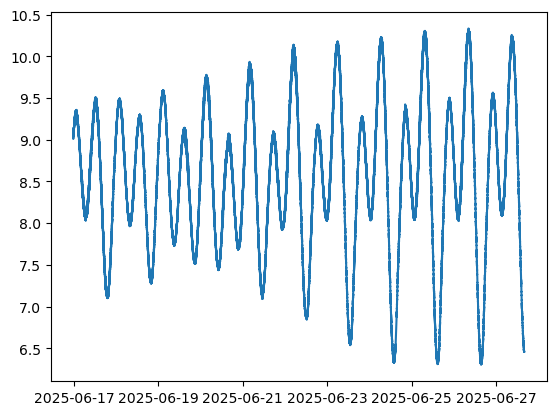

In [10]:
j0 = 51970
jf = -1500

plt.figure()
plt.plot(t[j0:jf], eta[j0:jf])
plt.show()

### For each file...

In [11]:
rbr_etas  = []
rbr_times = []
rbr_raws = []

for rbrf in RBR_files:
    r = RSK(rbrf)
    r.open()
    r.readdata()
    r.deriveseapressure()
    r.derivedepth(latitude=46.69)

    t = r.data['timestamp']
    rbr_times.append(t)
    seg_time = 600 # 10 minutes
    dt = 0.5
    seg_len = int(seg_time/dt)
    overlap = 0.5
    seg_starts = np.arange(0, len(t) - seg_len, overlap * seg_len, dtype=int)
    
    tf = t.astype('datetime64[ms]').astype(float)/1000 # seconds in float dtype
    p = r.data['sea_pressure'] * 10000                 # convert to Pascal (N/m^2)
    
    # Stuff for computing wavenumber & conversion factors...
    freq = np.abs(fftfreq(seg_len, d=dt))
    omega = 2 * np.pi * freq
    rho = 1025   # density of sea water in kg/m^3
    g = 9.81

    
    head = p / (rho * g)
    rbr_raws.append(head)
    
    # To save space, only use n arrays for averaging
    n_arrays = 3
    
    # Prepare to store etas and weights...
    etas = [np.zeros(len(tf)) for i in range(n_arrays)]
    weights = [np.zeros(len(tf)) for i in range(n_arrays)]
    
    for jj, i in enumerate(seg_starts):
        # key i to the array used
        j = jj % n_arrays
    
        # get segment and depth correct
        p_seg = p[i:i+seg_len]
        t_seg = tf[i:i+seg_len]
        t_seg = t_seg - t_seg[0]
        p_mean = np.nanmean(p_seg)
        h_mean = p_mean / (rho * g)
        p_slope, p_intercept, _, _, _  = scipy.stats.linregress(t_seg, p_seg - p_mean)
        p_trend = p_mean + p_intercept + t_seg*p_slope
        h_trend = p_trend / (rho * g)
        p_detrended = p_seg - p_trend
        F_p = fft(p_detrended)
        k = get_k_2d(omega, h_mean)
        to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2) 
        to_eta[freq == 0] = 0
        to_eta[freq > 0.3] = 0
        F_eta = F_p * to_eta
        eta_detrended = np.real(ifft(F_eta))
        eta = eta_detrended + h_trend
    
        # Put into the correct array
        etas[j][i:i+seg_len] = eta
        weights[j][i:i+seg_len] = cos_taper(np.ones(len(eta)))
    
    # Cast as arrays
    etas, weights = np.array(etas), np.array(weights)
    
    # Drop zero weights
    weight_sum = np.nansum(weights, axis=0)
    weight_ok = weight_sum > 0
    
    # Average
    eta = np.zeros(len(tf))
    eta[weight_ok] = np.average(etas[:,weight_ok], weights=weights[:,weight_ok], axis=0)

    # add to list
    rbr_etas.append(eta)

/tmp/ipykernel_42760/1622947651.py:56: RuntimeWarning: invalid value encountered in divide
  to_eta = (k * np.sinh(k*h_mean))/(rho * omega**2)
/tmp/ipykernel_42760/3885027161.py:5: RuntimeWarning: invalid value encountered in sqrt
  return omega / np.sqrt(g*h)


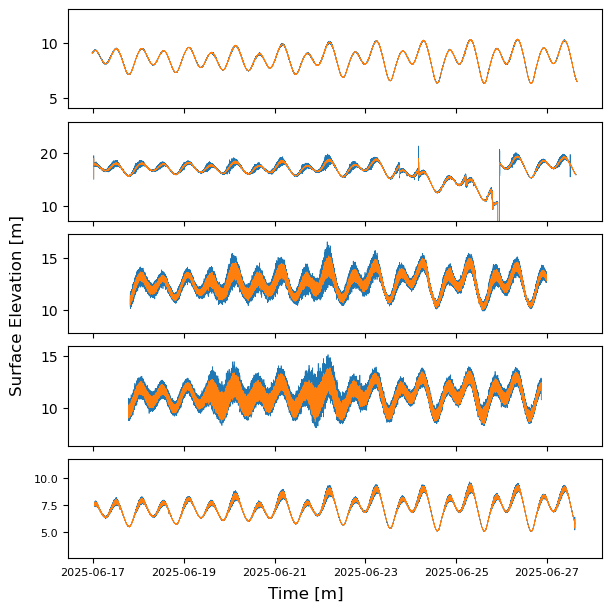

In [12]:
j0s = [51970,  5090, 16880, 17410, 2200]
jfs = [-1500,  -1000, -2000, -21300, -800]

fig, axs = plt.subplots(nrows=5, sharex=True, figsize=(6,6), constrained_layout=True)
for i in range(len(RBR_files)):
    t = rbr_times[i][j0s[i]:jfs[i]]
    e = rbr_etas[i][j0s[i]:jfs[i]]
    r = rbr_raws[i][j0s[i]:jfs[i]]
    axs[i].plot(t, e, linewidth=0.5)
    axs[i].plot(t, r, linewidth=0.5)
    axs[i].set_ylim(np.nanmean(e) - np.nanstd(e)*5, np.nanmean(e) + np.nanstd(e)*5)
plt.tick_params(labelsize=8)
fig.supylabel("Surface Elevation [m]")
fig.supxlabel("Time [m]")
plt.show()    

### Notes
There are some crazy jumps in the data but they're not from me, as evidenced by the fact they're in both the raw data and the processed version, so there's that at least. But its worth investigating some of these jumps...

### Clip times to remove bad data at beginning and end

In [13]:
j0s = [51970,  5090, 16880, 17410, 2200]
jfs = [-1500,  -1000, -2000, -21300, -800]

for i in range(len(RBR_files)):
    rbr_times[i] = rbr_times[i][j0s[i]:jfs[i]]
    rbr_etas[i] = rbr_etas[i][j0s[i]:jfs[i]]
    rbr_raws[i] = rbr_raws[i][j0s[i]:jfs[i]]

#### Unify Timestep

In [14]:
t0 = np.nanmin([np.nanmin(rt) for rt in rbr_times])
tf = np.nanmax([np.nanmax(rt) for rt in rbr_times])
t = np.arange(t0, tf + np.timedelta64(500, 'ms'), np.timedelta64(500, 'ms'))

In [15]:
new_etas = np.ones((5, len(t)))*np.nan
new_raws = np.ones((5, len(t)))*np.nan

for i in range(len(RBR_files)):

    # Case of a gap
    if i == 1:
        # I'm kind of winging it...
        gap_i = np.where(np.diff(rbr_times[i]) == np.timedelta64(447000, 'ms'))[0][0]
        gap_ti0 = np.where(t == rbr_times[i][gap_i])[0][0]
        gap_tif = np.where(t == rbr_times[i][gap_i+1])[0][0]
        
        ti0 = np.where(t == rbr_times[i][0])[0][0]
        tif = np.where(t == rbr_times[i][-1])[0][0]

        # Optional check everything is the right lengths...
        print(len(rbr_etas[i][:gap_i+1]), len(rbr_etas[i][gap_i+1:]))
        print(len(t[ti0:gap_ti0+1]), len(t[gap_tif:tif+1]))

        new_etas[i][ti0:gap_ti0+1] = rbr_etas[i][:gap_i+1]
        new_etas[i][gap_tif:tif+1] = rbr_etas[i][gap_i+1:]
        new_raws[i][ti0:gap_ti0+1] = rbr_raws[i][:gap_i+1]
        new_raws[i][gap_tif:tif+1] = rbr_raws[i][gap_i+1:]
        
    else:
        # Align with new etas...
        ti0 = np.where(t == rbr_times[i][0])[0][0]
        tif = np.where(t == rbr_times[i][-1])[0][0]
        new_etas[i][ti0:tif+1] = rbr_etas[i]
        new_raws[i][ti0:tif+1] = rbr_raws[i]

1539855 294255
1539855 294255


### Despike

In [41]:
# Method from Malcolm, modified
# If waves have a rayleigh distribution, 99.9% of waves will fall under ~2 x Hsig. 
# 3 to be extra safe... 
def despike_data(data, threshold=3.0, window=30*60*2):
    """Remove spikes from time series data using rolling median filter"""
    data = np.array(data)
    despiked = data.copy()
    
    df = pd.DataFrame({'data': data})
    rolling_median = df['data'].rolling(window=window, center=True).median()
    residuals = data - rolling_median

    std = np.nanstd(residuals)
    h_sig = 4 * std

    spike_mask = np.abs(residuals) > threshold * h_sig
    despiked[spike_mask] = np.nan
    
    return despiked

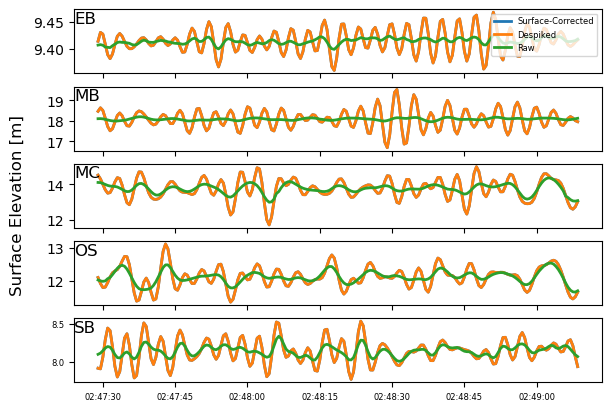

In [45]:
i0 =  886900
di =     200

fig, axs = plt.subplots(nrows=5, sharex=True, figsize=(6,4), constrained_layout=True)
for i in range(len(RBR_files)):
    axs[i].set_title(names[i], y=1.0, pad=-10, loc='left')
    e = new_etas[i]
    de = despike_data(e)
    r = new_raws[i]
    axs[i].plot(t[i0:i0+di], e[i0:i0+di], linewidth=2, label='Surface-Corrected')
    axs[i].plot(t[i0:i0+di], de[i0:i0+di], linewidth=2, label='Despiked')
    axs[i].plot(t[i0:i0+di], r[i0:i0+di], linewidth=2, label='Raw')
plt.tick_params(labelsize=6)
fig.supylabel("Surface Elevation [m]")
axs[0].legend(fontsize=6)
plt.show()    

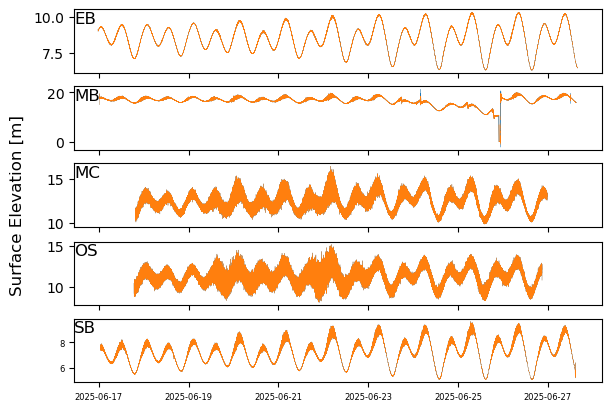

In [49]:
fig, axs = plt.subplots(nrows=5, sharex=True, figsize=(6,4), constrained_layout=True)
for i in range(len(RBR_files)):
    axs[i].set_title(names[i], y=1.0, pad=-10, loc='left')
    e = new_etas[i]
    de = despike_data(e)
    r = new_raws[i]
    axs[i].plot(t, e, linewidth=0.2)
    axs[i].plot(t, de, linewidth=0.2)
plt.tick_params(labelsize=6)
fig.supylabel("Surface Elevation [m]")
plt.show()

In [50]:
new_etas = np.array([despike_data(ne) for ne in new_etas])

Only some light de-spiking
## Construct 

In [51]:
# Order of coordinates is: EB, MB, MC, OS, SB
names = ['EB', 'MB', 'MC', 'OS', 'SB']
long_names = ['East Bay', 'Mid Bay', 'Mid Channel', 'Offshore', 'South Bay']
p_lat = [46.694, 46.690398, 46.715140, 46.721921, 46.6590193]
p_lon = [-123.993094, -124.003631, -124.083920, -124.15, -123.955138]

In [52]:
ds = xr.Dataset(
    data_vars={
        "eta":   (("time", "location"), new_etas.T),
        "p_raw": (("time", "location"), new_raws.T),
    },
    coords={
        "time": t,
        "location": names,
        "lon": ("location", p_lon),
        "lat": ("location", p_lat),
        "long_name": ("location", long_names)
    }
)

In [53]:
ds

<xarray.Dataset> Size: 162MB
Dimensions:    (time: 1846390, location: 5)
Coordinates:
  * time       (time) datetime64[ms] 15MB 2025-06-16T23:36:39 ... 2025-06-27T...
  * location   (location) <U2 40B 'EB' 'MB' 'MC' 'OS' 'SB'
    lon        (location) float64 40B -124.0 -124.0 -124.1 -124.2 -124.0
    lat        (location) float64 40B 46.69 46.69 46.72 46.72 46.66
    long_name  (location) <U11 220B 'East Bay' 'Mid Bay' ... 'South Bay'
Data variables:
    eta        (time, location) float64 74MB 9.09 nan nan nan ... nan nan nan
    p_raw      (time, location) float64 74MB 9.124 nan nan nan ... nan nan nan

In [54]:
ds.to_netcdf('/home/cassandra/Willapa/2025-experiment-1/anchorRBRs/rbr.nc')

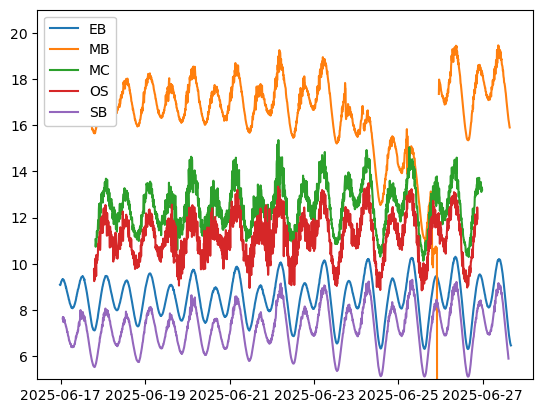

In [55]:
plt.figure()
for i in range(len(ds.location)):
    plt.plot(ds.time[::1000], ds.eta[:,i][::1000], label=ds.location.values[i])
plt.legend(loc=2, framealpha=1)
plt.ylim(5, 21)
plt.show()

From Malcolm's report: "The moorings held positions well except for MB which fouled on the instrument case, dragging the anchor.  The mooring was reset; it was off-station for less than one day and less than 1 km"